In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('ratings.csv')
data

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0
...,...,...,...
233301,1540125,DS0101EN,3.0
233302,1250651,PY0101EN,3.0
233303,1003832,CB0105ENv1,3.0
233304,922065,BD0141EN,3.0


In [5]:
user_rating_counts = data['user'].value_counts()
user_rating_counts

user
2          61
5          59
1653994    51
924030     51
746163     50
           ..
1058827     1
715501      1
763737      1
506416      1
711047      1
Name: count, Length: 33901, dtype: int64

In [6]:
users_with_more_than_2_ratings = user_rating_counts[user_rating_counts >= 2].index
users_with_more_than_2_ratings

Index([      2,       5, 1653994,  924030,  746163, 1761291,  382781,  971917,
       1559851, 1445103,
       ...
        435543, 1112795,   86305,  352985,  435122, 1776998,  295083,  481714,
        211118, 1776024],
      dtype='int64', name='user', length=25581)

In [7]:
# Create test data only for users who have rated more than 2 items
filtered_data = data[data['user'].isin(users_with_more_than_2_ratings)]

# Step 3: Split the filtered data into training and test sets (80% train, 20% test)
train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

# Step 4: Convert the training data into a user-item matrix
train_matrix = train_data.pivot_table(index='user', columns='item', values='rating')

# Step 5: Compute the similarity between users using cosine similarity
user_item_matrix = train_matrix.fillna(0)  # Fill NaN with 0 for similarity calculation
user_similarity = cosine_similarity(user_item_matrix)

# Convert the similarity matrix to DataFrame
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

RMSE: 0.08277049262136027


In [20]:
import matplotlib.pyplot as plt

## predict rating using similarity weight of each top k user rating

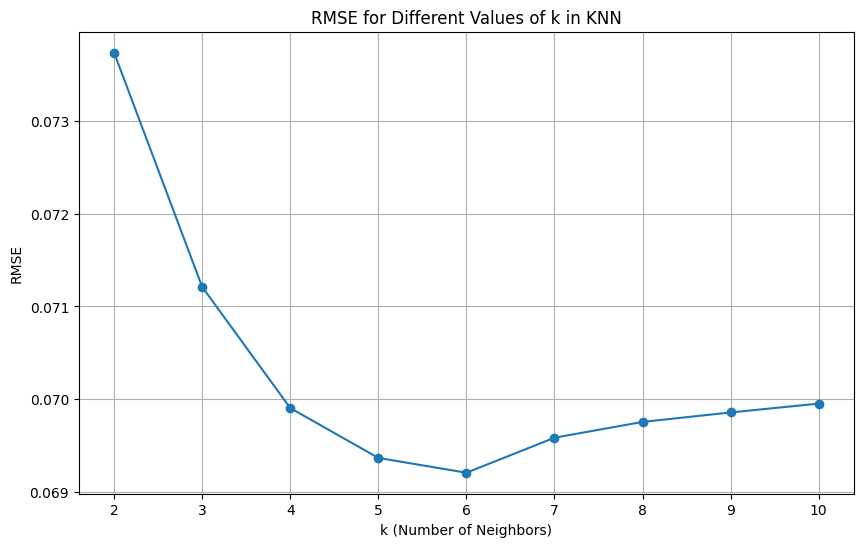

In [22]:
def predict_rating(user_id, item, k=3):
    # Check if the user exists in the training data
    if user_id not in user_similarity_df.index:
        return np.nan  # If the user is not in the training data, return NaN
    
    # Check if the item exists in the training matrix
    if item not in train_matrix.columns:
        return np.nan  # If the item is not in the training data, return NaN
    
    # Get similar users and their similarity scores
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    
    # Get the ratings of all similar users for the specified item
    ratings = train_matrix.loc[similar_users.index, item]
    
    # Filter out users who haven't rated the item (i.e., ratings == NaN)
    valid_ratings = ratings[ratings.notna()]
    
    # Now filter the similar_users list to include only users who rated the item
    valid_similar_users = similar_users.loc[valid_ratings.index]
    
    # Select the top k similar users who have rated the item
    top_k_users = valid_similar_users.index[:k]
    
    # Get the ratings of the top k similar users
    top_k_ratings = train_matrix.loc[top_k_users, item]
    
    if len(top_k_ratings) == 0:
        # If no neighbors have rated the item, return NaN
        return np.nan
    
    # Calculate the weighted sum of the ratings
    similarities = valid_similar_users.loc[top_k_users]
    weighted_ratings = top_k_ratings * similarities
    
    # Predict rating as the weighted average
    predicted_rating = weighted_ratings.sum() / similarities.sum()
    
    return predicted_rating

k_values = range(2, 11)  # Define the range of k values to test
rmse_values = []

for k in k_values:
    test_data['predicted_rating'] = test_data.apply(
        lambda row: predict_rating(row['user'], row['item'], k=k), axis=1
    )
    # Drop NaN predictions
    test_data_filtered = test_data.dropna(subset=['predicted_rating'])
    if not test_data_filtered.empty:
        rmse = np.sqrt(mean_squared_error(test_data_filtered['rating'], test_data_filtered['predicted_rating']))
        rmse_values.append(rmse)
    else:
        rmse_values.append(np.nan)  # If no predictions are made, append NaN for that k

# Step 7: Plot the RMSE values against the different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o')
plt.title('RMSE for Different Values of k in KNN')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.grid(True)
plt.show()



## predict rating only using average of top k user rating

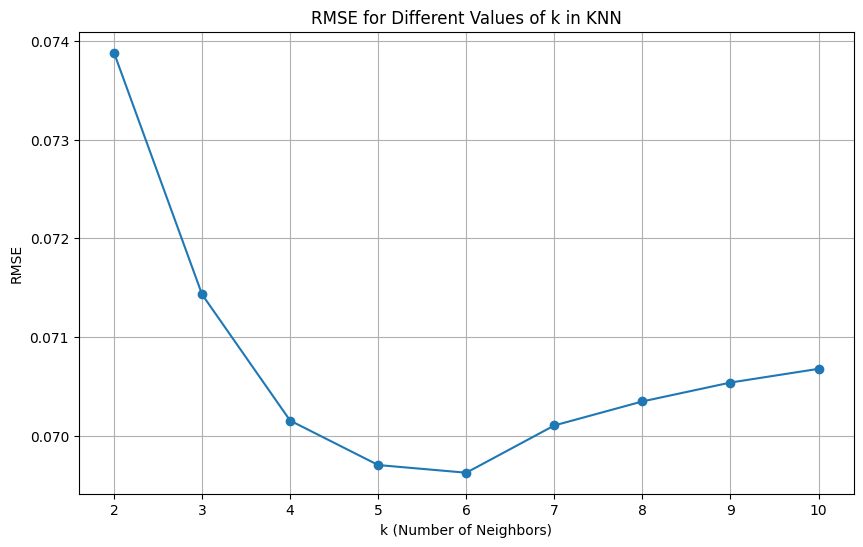

In [23]:
def predict_rating(user_id, item, k=3):
    # Check if the user exists in the training data
    if user_id not in user_similarity_df.index:
        return np.nan  # If the user is not in the training data, return NaN
    
    # Check if the item exists in the training matrix
    if item not in train_matrix.columns:
        return np.nan  # If the item is not in the training data, return NaN
    
    # Get similar users and their similarity scores
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    
    # Get the ratings of all similar users for the specified item
    ratings = train_matrix.loc[similar_users.index, item]
    
    # Filter out users who haven't rated the item (i.e., ratings == NaN)
    valid_ratings = ratings[ratings.notna()]
    
    # Now filter the similar_users list to include only users who rated the item
    valid_similar_users = similar_users.loc[valid_ratings.index]
    
    # Select the top k similar users who have rated the item
    top_k_users = valid_similar_users.index[:k]
    
    # Get the ratings of the top k similar users
    top_k_ratings = train_matrix.loc[top_k_users, item]
    
    if len(top_k_ratings) == 0:
        # If no neighbors have rated the item, return NaN
        return np.nan
    
    # Calculate the weighted sum of the ratings
    # similarities = valid_similar_users.loc[top_k_users]
    # weighted_ratings = top_k_ratings * similarities
    
    # Predict rating as the weighted average
    predicted_rating = top_k_ratings.sum() / len(top_k_ratings)
    
    return predicted_rating

k_values = range(2, 11)  # Define the range of k values to test
rmse_values = []

for k in k_values:
    test_data['predicted_rating'] = test_data.apply(
        lambda row: predict_rating(row['user'], row['item'], k=k), axis=1
    )
    # Drop NaN predictions
    test_data_filtered = test_data.dropna(subset=['predicted_rating'])
    if not test_data_filtered.empty:
        rmse = np.sqrt(mean_squared_error(test_data_filtered['rating'], test_data_filtered['predicted_rating']))
        rmse_values.append(rmse)
    else:
        rmse_values.append(np.nan)  # If no predictions are made, append NaN for that k

# Step 7: Plot the RMSE values against the different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o')
plt.title('RMSE for Different Values of k in KNN')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.grid(True)
plt.show()

